In [1]:
import numpy as np                          # Array creation & manipulation
import matplotlib.pyplot as plt             # Plotting
#plt.style.use('default')            # Choose a plot style that suits your environment ('default', 'classic', 'dark_background
import gpytorch
import torch
torch.set_default_dtype(torch.double) #added this because of https://github.com/pytorch/botorch/issues/2182
import json
import scipy
import os
import datetime 
from openpmd_viewer.addons import LpaDiagnostics

In [2]:
#i made fbpic_wrapper into a package to be able to handle it easier
from fbpic_wrapper import SimForeman

Beam Waist
9.614426189210296e-06
RMS Beam Duration (exp(-t^2/tau^2))
2.972626301008067e-14
Angular Frequency
2354564459136066.5
Peak Intensity in W/cm^2
2.6220034246575346e+19
Normalized Vector Potential
3.5
Peak Electric Field in TV/m
14.043750000000001
Pulse Energy in Joules
2.2596571232291924


RMS Beam Duration (exp(-t^2/tau^2))
2.5479654008640572e-14
Beam Waist (exp(-2r^2/w0^2))
8.280887552808186e-06
Angular Frequency
2354564459136066.5
Peak Intensity in W/cm^2
9.439212328767126e+18
Normalized Vector Potential
2.1
Peak Electric Field in TV/m
8.426250000000001
Pulse Energy in Joules
0.5172557075367022
RMS Beam Duration (exp(-t^2/tau^2))
2.5479654008640572e-14
Peak Intensity in W/cm^2
1.3377568493150687e+19
Peak Electric Field in TV/m
10.031250000000002
Pulse Energy in Joules
0.2672593780106513


In [3]:
#define initial sim foldernur
initial_sims="path"
initial_results =  np.load(initial_sims+"results.npz")
num_init_sims=initial_results['x_train'].size #14#8#10

In [4]:
#define old runs that should be included in the initial x and y data
old_runs = [] #["path"]
x_old=np.empty(0)
y_old=np.empty(0)
for old_run in old_runs:
    old_results = np.load(old_run+"results.npz")
    x_old = np.append(x_old, old_results['x_train'])
    y_old = np.append(y_old, old_results['max_chrg_in_bounds'])
    uz_bounds = old_results['uz_bounds']

In [5]:
run = 'run_simple'+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
try:
    os.mkdir("path"+run)
except:
    print('Path exists')

In [6]:
#modifying sys.argv to succesfully call SimForeman or other scripts that only work with args
import sys
from contextlib import contextmanager

@contextmanager
def patched_argv(new_args):
    original_argv = sys.argv
    sys.argv = new_args
    try:
        yield
    finally:
        sys.argv = original_argv

In [7]:
#get all folders in a directory
def get_folders(path):
    try:
        all_entries = [os.path.join(path, d) for d in os.listdir(path)]
        folders = [entry for entry in all_entries if os.path.isdir(entry)]
    except:
        print('Smth went wrong when trying to list all folders in path')
    return folders

In [8]:
#get initial results
if x_old.size == 0:
    x_train = initial_results['x_train']
    y_train = initial_results['max_chrg_in_bounds']
    uz_bounds = initial_results['uz_bounds']
    max_chrg_it = initial_results['max_chrg_it']
else:
    x_train = x_old
    y_train = np.append(initial_results['max_chrg_in_bounds'],y_old)
    max_chrg_it = np.append(initial_results['max_chrg_it'],old_results['max_chrg_it'])

max_chrg_in_bounds = y_train


In [9]:
with open('params-to-opt.json','r') as file:
    boundsD = json.load(file)
bounds=np.array([boundsD['laser_params']['a0'],boundsD['laser_params']['waist'],boundsD['laser_params']['zf'],boundsD['other_params']['species']['Hydrogen']['profile_params']['plateau'],boundsD['other_params']['species']['Nitrogen']['profile_params']['start'],boundsD['other_params']['species']['Nitrogen']['density']])

In [10]:
#initialize tensors

x_trainT = torch.from_numpy(x_train).view(-1,1)
max_chrg_in_boundsT = torch.from_numpy(np.abs(y_train)).view(-1,1)
boundsT =torch.from_numpy(bounds).T
boundsNitrogenT = torch.from_numpy(np.array(boundsD['other_params']['species']['Nitrogen']['density'])).view(2,1)
#boundsNitrogenT2 = torch.from_numpy(np.array([boundsD['other_params']['species']['Nitrogen']['density']]))

print(x_trainT)

tensor([[1.0500e+23],
        [1.3225e+23],
        [1.4272e+23],
        [1.1492e+23],
        [6.7875e+22],
        [7.8924e+22],
        [1.1500e+23],
        [8.5732e+22],
        [1.2500e+23],
        [6.3154e+22],
        [1.1000e+23],
        [1.0000e+23],
        [1.2000e+23],
        [9.5000e+22]])


In [11]:
#get latest folder in a file 
def latest_scan_entry(run):
    latest_folder = max(get_folders('./scans/'+run), key=os.path.getmtime, default=None)
    return latest_folder


In [12]:
max_chrg_in_boundsT

tensor([[2.0354e-11],
        [3.5513e-11],
        [1.9515e-11],
        [3.5407e-11],
        [2.8312e-13],
        [7.2806e-13],
        [3.8046e-11],
        [1.6200e-12],
        [4.2015e-11],
        [1.4280e-13],
        [3.4390e-11],
        [1.5113e-11],
        [3.9472e-11],
        [7.2220e-12]])

In [13]:
x_trainT

tensor([[1.0500e+23],
        [1.3225e+23],
        [1.4272e+23],
        [1.1492e+23],
        [6.7875e+22],
        [7.8924e+22],
        [1.1500e+23],
        [8.5732e+22],
        [1.2500e+23],
        [6.3154e+22],
        [1.1000e+23],
        [1.0000e+23],
        [1.2000e+23],
        [9.5000e+22]])

x_train: tensor([[1.0500e+23],
        [1.3225e+23],
        [1.4272e+23],
        [1.1492e+23],
        [6.7875e+22],
        [7.8924e+22],
        [1.1500e+23],
        [8.5732e+22],
        [1.2500e+23],
        [6.3154e+22],
        [1.1000e+23],
        [1.0000e+23],
        [1.2000e+23],
        [9.5000e+22]])


/hkfs/home/project/hk-project-p0024137/ng8194/fbpicBO/lib64/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/hkfs/home/project/hk-project-p0024137/ng8194/fbpicBO/lib64/python3.11/site-packages/botorch/optim/optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params0.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-44-19
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-44-19 2025-08-28_22-44-19
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 186.99it/s]


Making Scatter Plot
Making Profile
39600
2.7453010632266888


100%|██████████| 50/50 [00:00<00:00, 89.20it/s]


(np.float64(412.4895833333657), np.float64(0.18302117648224037))
Making Energies
Q = 98.10 (pC)


100%|██████████| 50/50 [00:00<00:00, 357.60it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params1.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-46-04
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-46-04 2025-08-28_22-46-04
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 191.54it/s]


Making Scatter Plot
Making Profile
39600
2.6973930859835633


100%|██████████| 50/50 [00:00<00:00, 89.48it/s]


(np.float64(412.4895833333657), np.float64(0.17982724026466407))
Making Energies
Q = 102.16 (pC)


100%|██████████| 50/50 [00:00<00:00, 365.62it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params2.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-47-40
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-47-40 2025-08-28_22-47-40
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 189.03it/s]


Making Scatter Plot
Making Profile
39600
2.2907658251388305


100%|██████████| 50/50 [00:00<00:00, 87.67it/s]


(np.float64(412.4895833333657), np.float64(0.15271815300608674))
Making Energies
Q = 49.01 (pC)


100%|██████████| 50/50 [00:00<00:00, 353.73it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params3.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-49-14
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-49-14 2025-08-28_22-49-14
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 189.70it/s]


Making Scatter Plot
Making Profile
39600
2.571349379290396


100%|██████████| 50/50 [00:00<00:00, 88.50it/s]


(np.float64(412.4895833333657), np.float64(0.1714241395083566))
Making Energies
Q = 73.52 (pC)


100%|██████████| 50/50 [00:00<00:00, 348.23it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params4.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-50-47
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-50-47 2025-08-28_22-50-47
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 191.67it/s]


Making Scatter Plot
Making Profile
39600
2.605646352030016


100%|██████████| 50/50 [00:00<00:00, 89.50it/s]


(np.float64(412.4895833333657), np.float64(0.1737106552347541))
Making Energies
Q = 80.46 (pC)


100%|██████████| 50/50 [00:00<00:00, 348.02it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params5.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-52-21
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-52-21 2025-08-28_22-52-21
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 185.01it/s]


Making Scatter Plot
Making Profile
39600
2.4347623661493207


100%|██████████| 50/50 [00:00<00:00, 87.61it/s]


(np.float64(412.4895833333657), np.float64(0.16231813601528602))
Making Energies
Q = 51.70 (pC)


100%|██████████| 50/50 [00:00<00:00, 352.34it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params6.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-53-57
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-53-57 2025-08-28_22-53-57
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 184.38it/s]


Making Scatter Plot
Making Profile
39600
2.4326671358156555


100%|██████████| 50/50 [00:00<00:00, 88.50it/s]


(np.float64(412.4895833333657), np.float64(0.16217845088491833))
Making Energies
Q = 58.72 (pC)


100%|██████████| 50/50 [00:00<00:00, 134.34it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params7.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-55-30
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-55-30 2025-08-28_22-55-30
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 152.64it/s]


Making Scatter Plot
Making Profile
39600
2.5187071663355827


100%|██████████| 50/50 [00:00<00:00, 87.08it/s]


(np.float64(412.4895833333657), np.float64(0.16791458055377007))
Making Energies
Q = 70.33 (pC)


100%|██████████| 50/50 [00:00<00:00, 350.90it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params8.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-57-03
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-57-03 2025-08-28_22-57-03
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 187.85it/s]


Making Scatter Plot
Making Profile
39600
2.339133573533628


100%|██████████| 50/50 [00:00<00:00, 89.22it/s]


(np.float64(412.4895833333657), np.float64(0.15594274131581187))
Making Energies
Q = 39.48 (pC)


100%|██████████| 50/50 [00:00<00:00, 355.83it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.

Unable to find non-zero acquisition function values - initial conditions are being selected randomly.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple2025-08-28_22-44-19/iter_params9.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-58-37
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-372024-05-14_12-54-37 2025-08-28_22-58-37 2025-08-28_22-58-37
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time taken

100%|██████████| 50/50 [00:00<00:00, 185.78it/s]


Making Scatter Plot
Making Profile
39600
2.7161646622169955


100%|██████████| 50/50 [00:00<00:00, 89.24it/s]


(np.float64(412.4895833333657), np.float64(0.1810787065265079))
Making Energies
Q = 106.34 (pC)


100%|██████████| 50/50 [00:00<00:00, 350.63it/s]


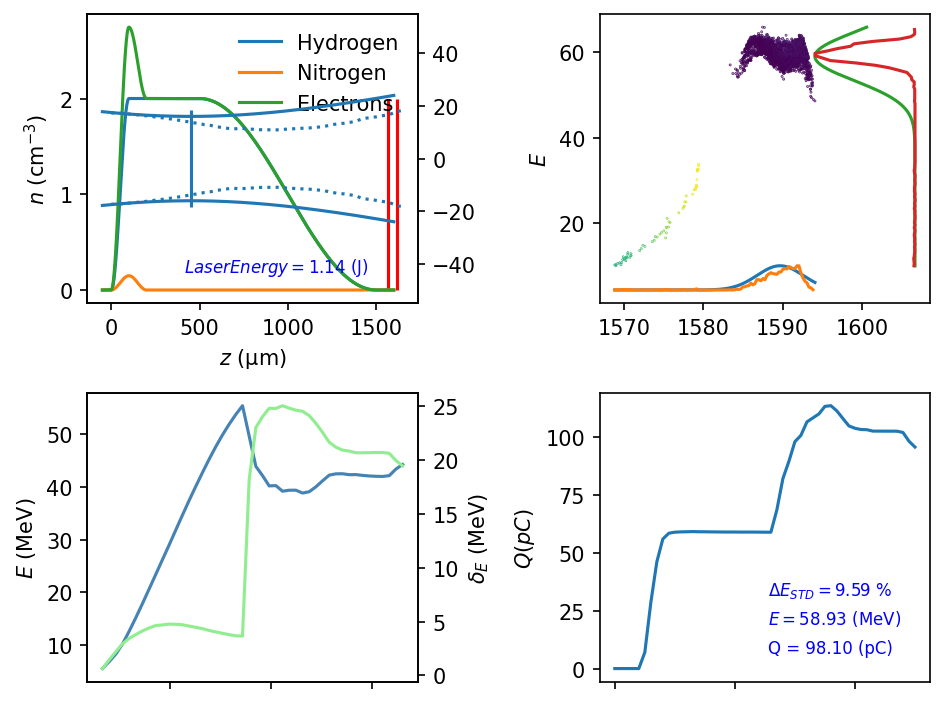

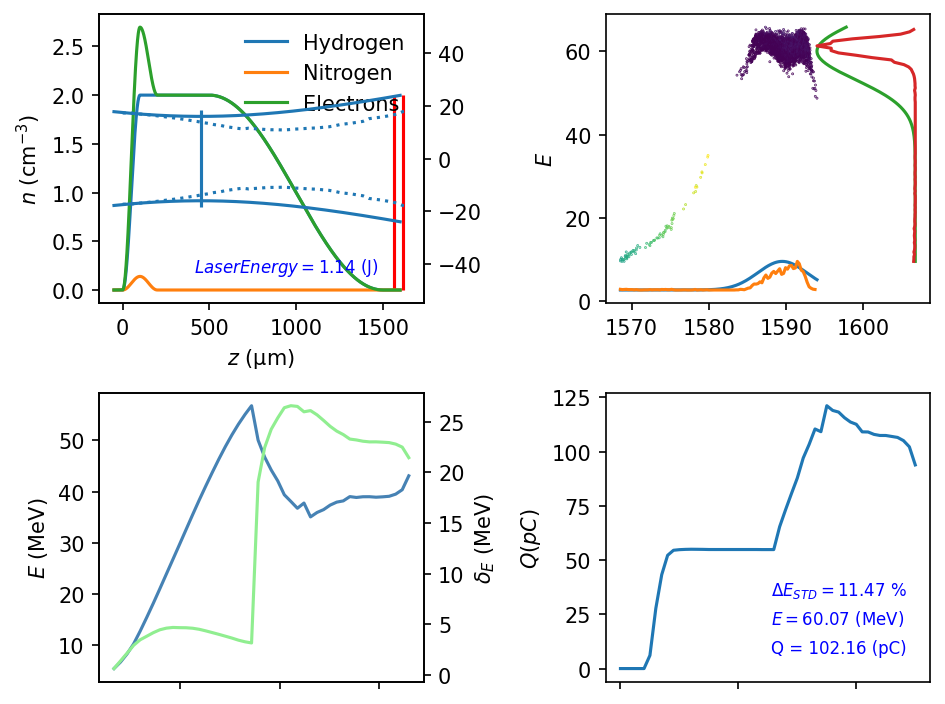

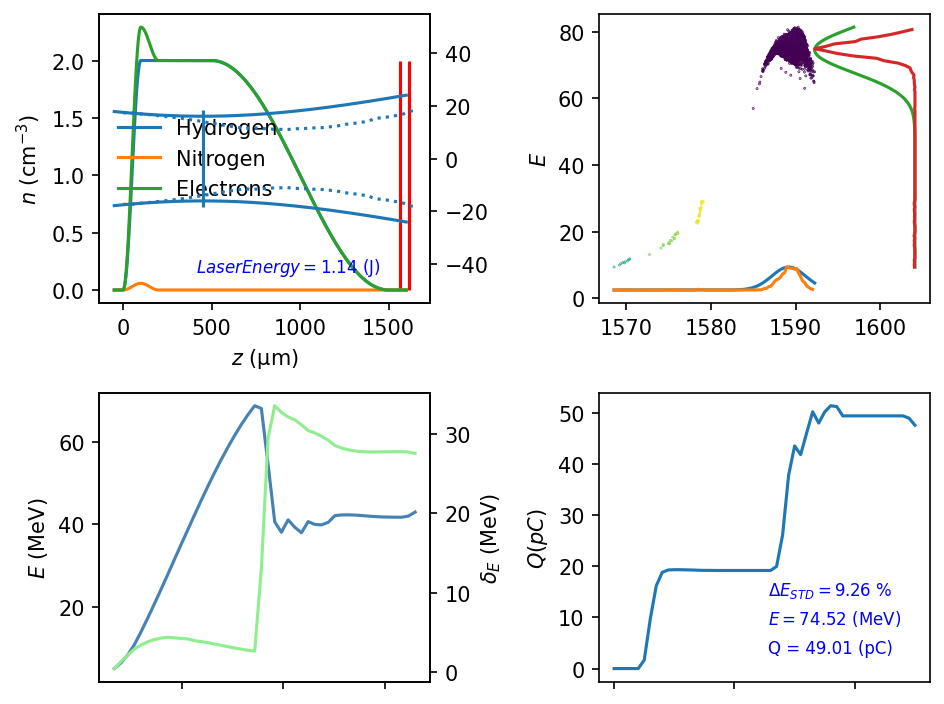

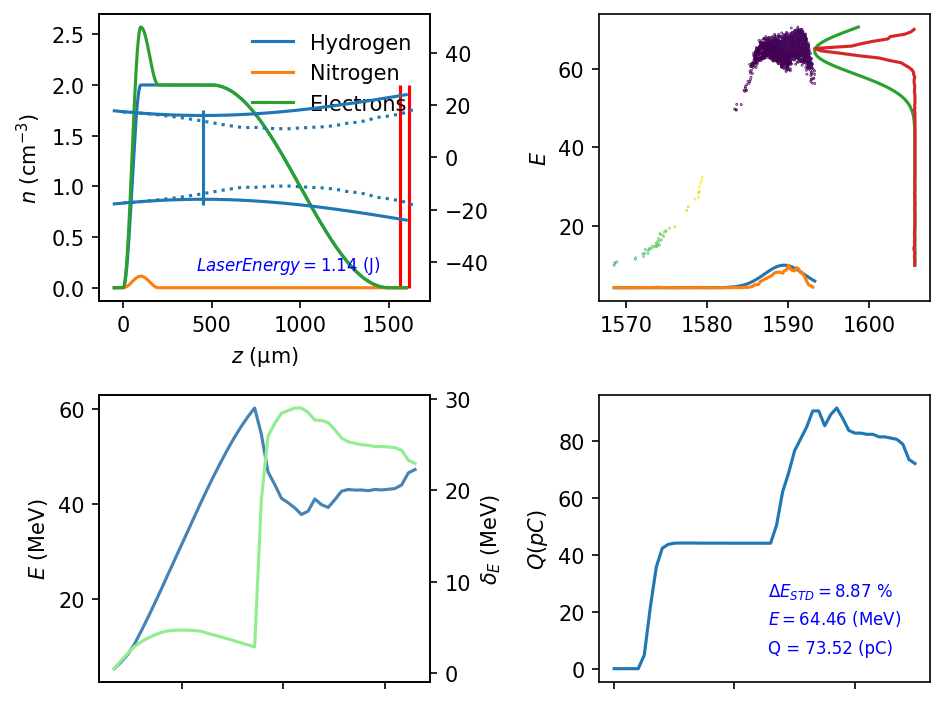

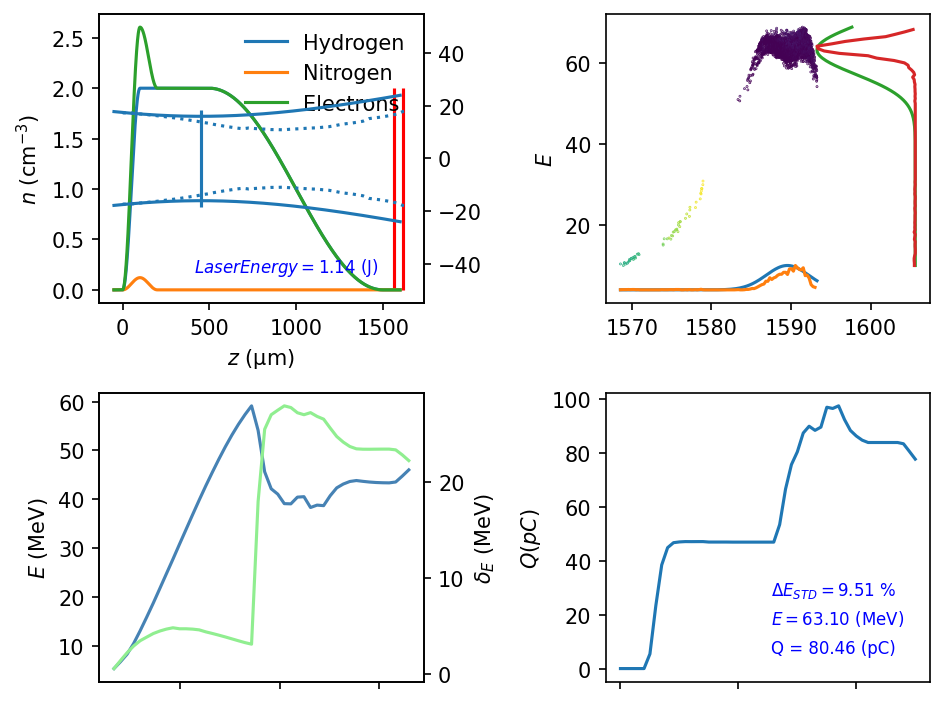

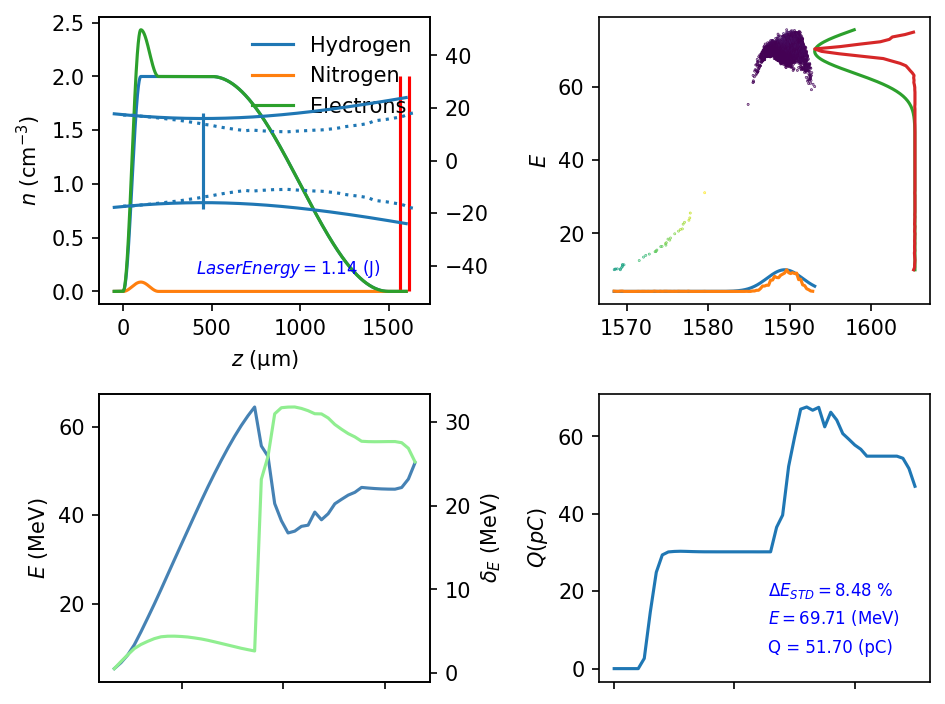

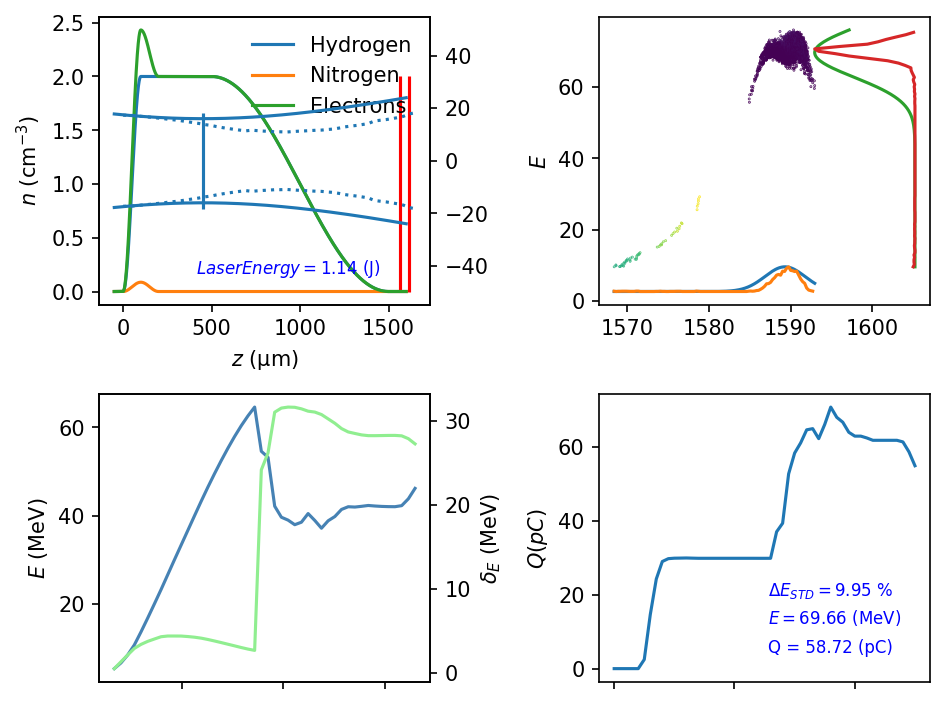

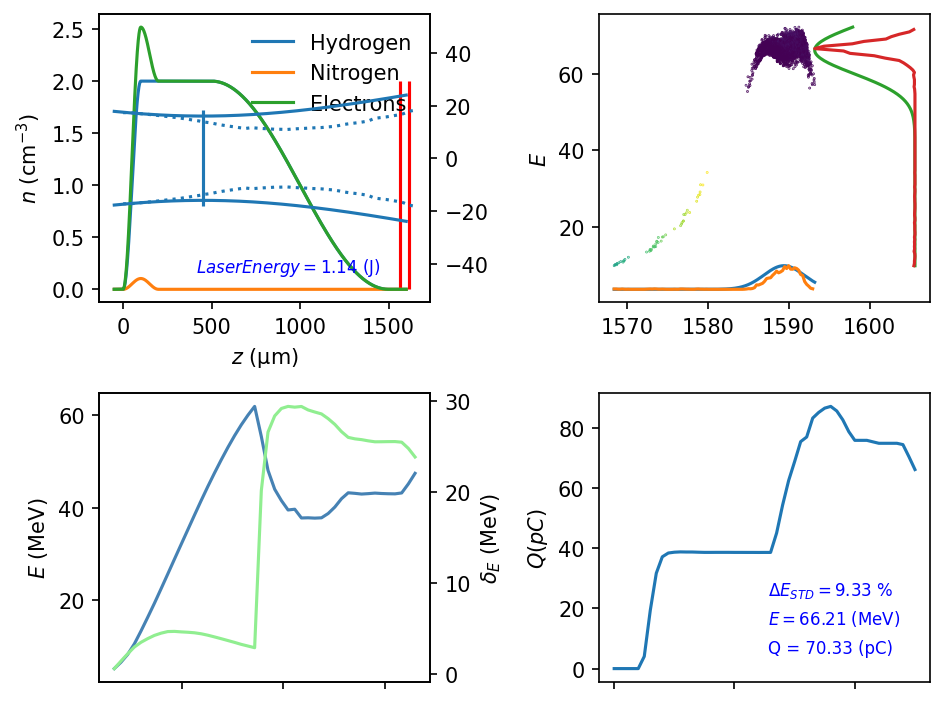

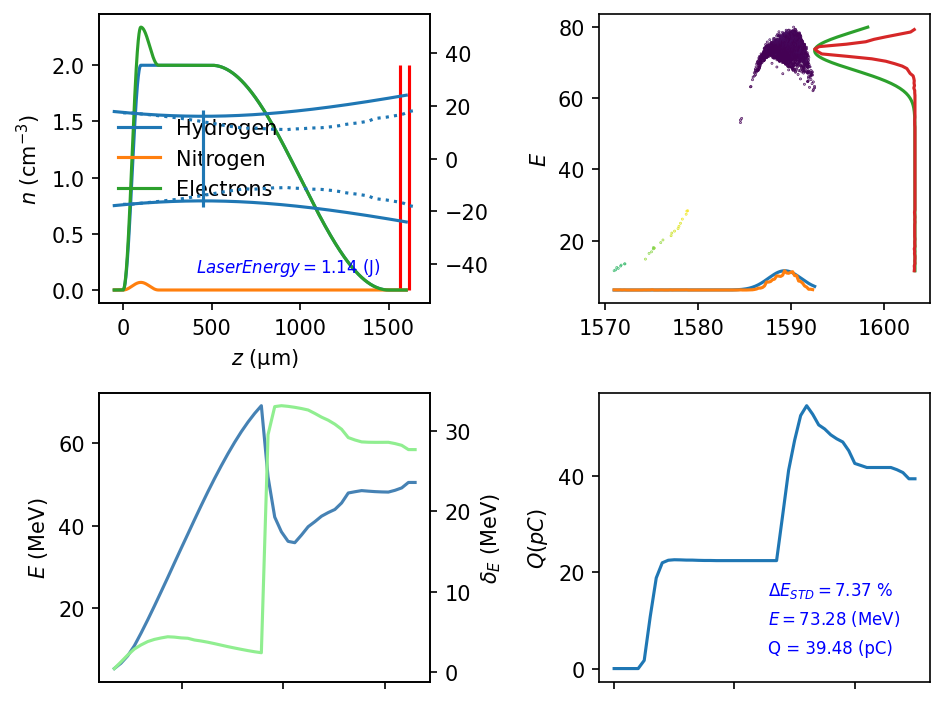

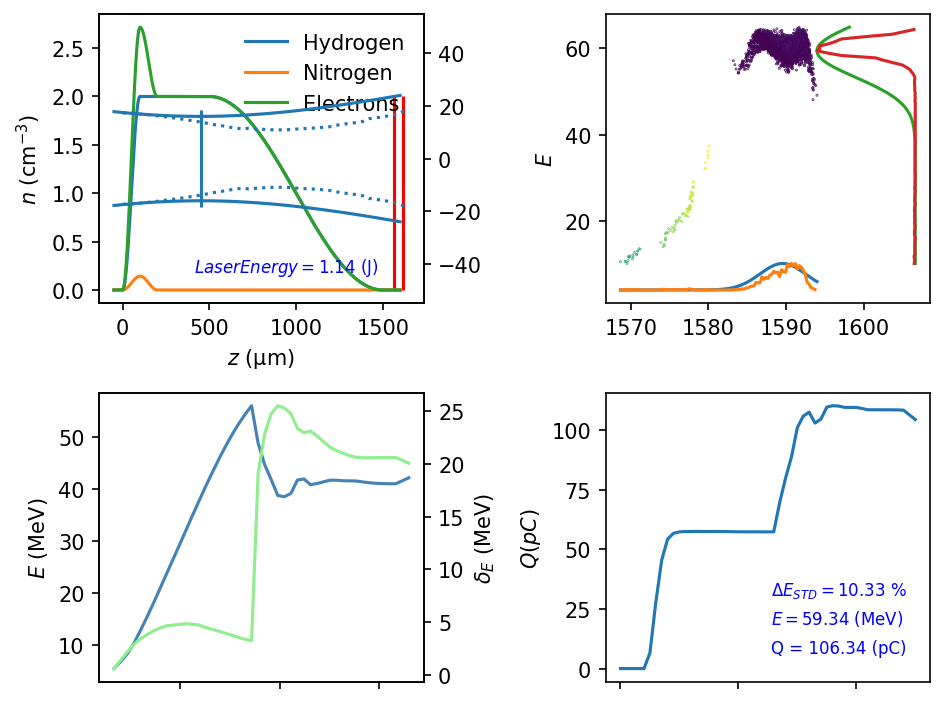

In [14]:
## https://github.com/pytorch/botorch/issues/2182

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms import Standardize
from botorch.utils.transforms import unnormalize, normalize
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement
from botorch.acquisition import UpperConfidenceBound

from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

from botorch.sampling.normal import SobolQMCNormalSampler

from gpytorch.mlls import ExactMarginalLogLikelihood

from copy import deepcopy

BATCH_SIZE=1
#no clue which parameters should be chosen here, copied it from tutorial
NUM_RESTARTS=10
RAW_SAMPLES=256
MC_SAMPLES = 128

Y_SCALE_FCTR = 1e13

print('x_train:',x_trainT)
x_trainT = normalize(x_trainT,boundsNitrogenT)


#scale objective, to have small std in relation
y_scaled = max_chrg_in_boundsT * Y_SCALE_FCTR

model_cps = []
data_cps = []

for i in range(10):
    train_Yvar = torch.full_like(y_scaled, 1e-6) #apparently needed for noise free observations, otherwise inferred https://botorch.readthedocs.io/en/stable/models.html#botorch.models.gp_regression.SingleTaskGP
    model = SingleTaskGP(x_trainT, y_scaled, train_Yvar, outcome_transform=Standardize(1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)#SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    # optimize
    acq_func = UpperConfidenceBound(model=model, beta=0.5)
    
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=boundsNitrogenT,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )
    
    # observe new values
    x_trainT = torch.cat([x_trainT, normalize(candidates,boundsNitrogenT)])
    new_x_train = candidates.detach()
    with open(initial_sims+'init_params10.json','r') as file:
        params = json.load(file)
    params['other_params']['species']['Nitrogen']['density'] = float(new_x_train)
    params['Path'] = "path"+run
    with open("path"+run+f'/iter_params{i}.json', 'w') as json_file:
        json.dump(params, json_file)
    print('----------------------')
    with patched_argv(['SimForeman.py', '--json=load', '--File='+"path"+run+f'/iter_params{i}.json', '--Debug', '--Summarize']):
        SimForeman.main()
        
    ts_2d = LpaDiagnostics(latest_scan_entry(run)+'/diags/hdf5/')
    
    charge_in_bounds = ts_2d.iterate(ts_2d.get_charge, species ='Electrons', select = {'uz':uz_bounds})[39:]#only charges from iteration 40-50, to avoid perverse optimization
    max_chrg_in_bounds = np.append(max_chrg_in_bounds,np.abs(charge_in_bounds[int(np.nanargmin(charge_in_bounds))]))

    max_chrg_in_boundsT = torch.cat([max_chrg_in_boundsT,torch.tensor([[np.abs(charge_in_bounds[int(np.nanargmin(charge_in_bounds))])]])])
    max_chrg_it = np.append(max_chrg_it,int(np.nanargmin(charge_in_bounds)))
    y_scaled = torch.cat([y_scaled,torch.tensor([[np.abs(charge_in_bounds[int(np.nanargmin(charge_in_bounds))])*Y_SCALE_FCTR]])]) 
    #data_cps.append((x_train, y_train))
    #model_cps.append(deepcopy(model))
    

In [15]:
#save inputs and outputs:
np.savez('./scans/'+run+'/results.npz',x_train=unnormalize(x_trainT, boundsNitrogenT).numpy(), max_chrg_in_bounds=max_chrg_in_bounds,max_chrg_it=max_chrg_it,uz_bounds=uz_bounds)

In [16]:
#vis

In [17]:
unnormalize(x_trainT, boundsNitrogenT)

tensor([[1.0500e+23],
        [1.3225e+23],
        [1.4272e+23],
        [1.1492e+23],
        [6.7875e+22],
        [7.8924e+22],
        [1.1500e+23],
        [8.5732e+22],
        [1.2500e+23],
        [6.3154e+22],
        [1.1000e+23],
        [1.0000e+23],
        [1.2000e+23],
        [9.5000e+22],
        [1.4906e+23],
        [1.3948e+23],
        [5.8154e+22],
        [1.1427e+23],
        [1.2113e+23],
        [8.6954e+22],
        [8.6535e+22],
        [1.0374e+23],
        [6.7828e+22],
        [1.4324e+23]])

In [18]:
max_chrg_in_bounds

array([-2.03540585e-11, -3.55128604e-11, -1.95146202e-11, -3.54070135e-11,
       -2.83121694e-13, -7.28062074e-13, -3.80457263e-11, -1.61997102e-12,
       -4.20147008e-11, -1.42801032e-13, -3.43900645e-11, -1.51132443e-11,
       -3.94722207e-11, -7.22201425e-12,  1.19862759e-11,  2.87519911e-11,
        8.71400774e-14,  3.71044053e-11,  4.05192956e-11,  1.80656004e-12,
        1.43235853e-12,  2.26287012e-11,  2.65549681e-13,  1.82981861e-11])

In [19]:
max_chrg_it

array([11,  0,  0,  9,  9,  5, 11, 11,  0,  5, 11, 11,  3, 11,  0,  0,  9,
       11,  2, 11, 11, 11,  7,  0])

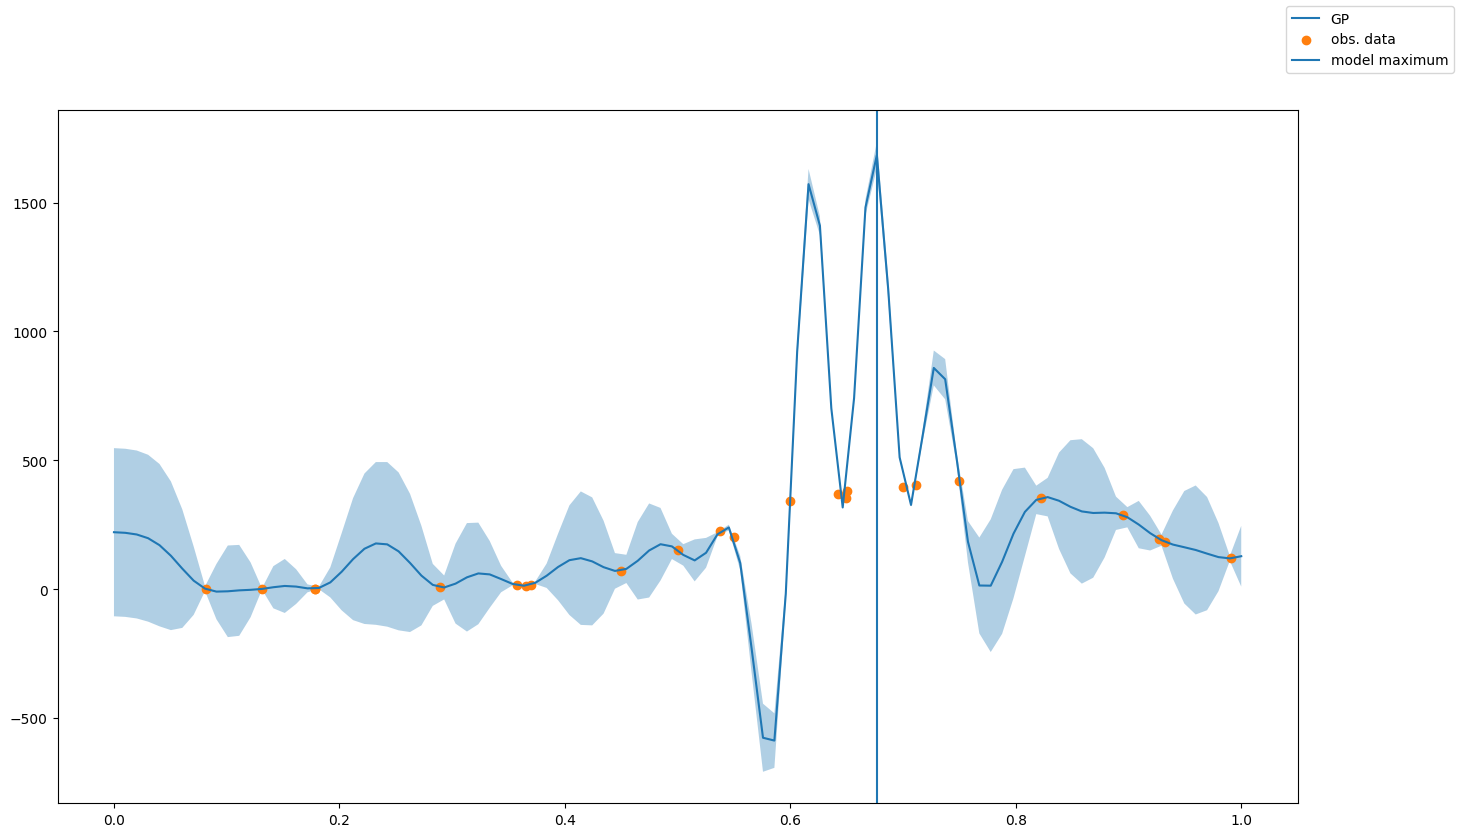

In [20]:
#Visualize

#model_copy = deepcopy(model)

fig, ax = plt.subplots(figsize=(16, 9))
with torch.no_grad():
    x_test = torch.linspace(0,1,100)
    m = model.posterior(x_test).mean.squeeze()
    s = model.posterior(x_test).variance.sqrt().squeeze()
    ax.plot(x_test, m.numpy(), label="GP")
    ax.fill_between(x_test, m+2*s, m-2*s, alpha=0.35)
    #ax.plot(x_test, toy_model(x_test.numpy(), noise_std=0), label="ground truth", ls="--")
    ax.scatter(x_trainT.numpy(), y_scaled.numpy(), label="obs. data")
    #ax.set_title(f"Iteration={i}")
    ax.axvline(x_test[m.argmax()], label="model maximum")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)#,loc='center')
    fig.savefig('./scans/'+run+'/BO_fig-scaled.pdf', format="pdf")

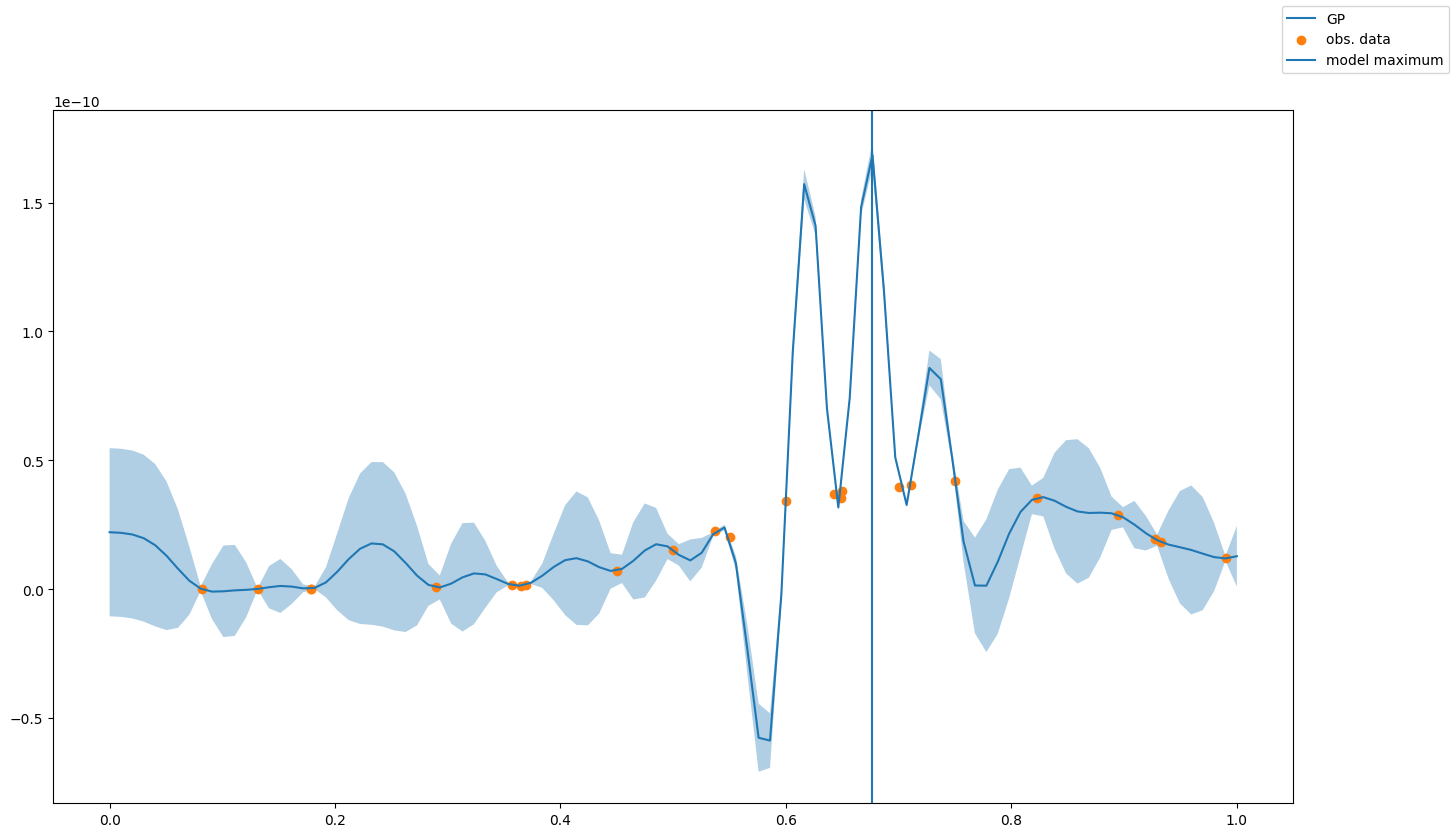

In [21]:
#Visualize

#model_copy = deepcopy(model)

fig, ax = plt.subplots(figsize=(16, 9))
with torch.no_grad():
    x_test = torch.linspace(0,1,100)
    m = model.posterior(x_test).mean.squeeze()/Y_SCALE_FCTR
    s = model.posterior(x_test).variance.sqrt().squeeze()/Y_SCALE_FCTR
    ax.plot(x_test, m.numpy(), label="GP")
    ax.fill_between(x_test, m+2*s, m-2*s, alpha=0.35)
    #ax.plot(x_test, toy_model(x_test.numpy(), noise_std=0), label="ground truth", ls="--")
    ax.scatter(x_trainT.numpy(), y_scaled.numpy()/Y_SCALE_FCTR, label="obs. data")
    #ax.set_title(f"Iteration={i}")
    ax.axvline(x_test[m.argmax()], label="model maximum")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)#,loc='center')
    fig.savefig('./scans/'+run+'/BO_fig.pdf', format="pdf")